Handling Big Datasets using:


*   dataframe subsets
*   different datatypes
*  pyarrow
*   iterative computation
*   dask
*   polars






In [7]:
import pandas as pd
import numpy as np
filename="/content/yellow_tripdata_2021-02.parquet"
df=pd.read_parquet(filename)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-02-01 00:40:47,2021-02-01 00:48:28,1.0,2.30,1.0,N,141,226,2,8.5,3.0,0.5,0.00,0.0,0.3,12.30,2.5,NaN
1,1,2021-02-01 00:07:44,2021-02-01 00:20:31,1.0,1.60,1.0,N,43,263,2,9.5,3.0,0.5,0.00,0.0,0.3,13.30,0.0,NaN
2,1,2021-02-01 00:59:36,2021-02-01 01:24:13,1.0,5.30,1.0,N,114,263,2,19.0,3.0,0.5,0.00,0.0,0.3,22.80,2.5,NaN
3,2,2021-02-01 00:03:26,2021-02-01 00:16:32,1.0,2.79,1.0,N,236,229,1,11.0,0.5,0.5,2.96,0.0,0.3,17.76,2.5,NaN
4,2,2021-02-01 00:20:20,2021-02-01 00:24:03,2.0,0.64,1.0,N,229,140,1,4.5,0.5,0.5,1.66,0.0,0.3,9.96,2.5,NaN


In [56]:
# measure memory
mb=1_000_000
df.memory_usage(deep=True).sum()/mb

np.float64(282.308734)

In [57]:
# file size
from pathlib import Path
Path(filename).stat().st_size/mb

33.730552

In [58]:
# calculate median distance by vendorId
df.groupby("VendorID")["trip_distance"].median()

,trip_distance
VendorID,
1,1.60
2,1.74


In [59]:
# load subset by columns
columns=["VendorID","trip_distance"]
df_subset=pd.read_parquet(filename,columns=columns)
df_subset.head()

,VendorID,trip_distance
0,1,2.30
1,1,1.60
2,1,5.30
3,2,2.79
4,2,0.64


In [60]:
#less memory used for subset
df_subset.memory_usage(deep=True).sum()/mb

np.float64(32.592408)

In [61]:
df.dtypes

,0
VendorID,int64
tpep_pickup_datetime,datetime64[us]
tpep_dropoff_datetime,datetime64[us]
passenger_count,float64
trip_distance,float64
RatecodeID,float64
store_and_fwd_flag,object
PULocationID,int64
DOLocationID,int64
payment_type,int64


In [62]:
df.shape

(1358017, 19)

In [63]:
df['total_amount'].describe()

,total_amount
count,1.358017e+06
mean,1.743016e+01
std,1.455326e+01
min,-6.348000e+02
25%,1.100000e+01
50%,1.415000e+01
75%,1.930000e+01
max,6.969300e+03


In [64]:
#float 64
df['total_amount'].memory_usage(deep=True)/mb

21.728272

In [65]:
#float 32 (lesser memory usage)
amount=df['total_amount'].astype("float32")
amount.memory_usage(deep=True)/mb

16.296204

Categorical Data

In [66]:
names = {
    1: "Creative",
    2: "VeriFone",
}
df['Vendor_Name'] = df['VendorID'].map(names)

In [67]:
id_size=df['VendorID'].memory_usage(deep=True)/mb
print(f"ID size: {id_size}")
name_size=df['Vendor_Name'].memory_usage(deep=True)/mb
print(f"Name size: {name_size}")
#name size takes more space

ID size: 21.728272
Name size: 99.135241


In [68]:
df['Vendor']=df['Vendor_Name'].astype('category')
cat_size=df['Vendor'].memory_usage(deep=True)/mb
print(f"Category size: {cat_size}")

Category size: 12.222391


In [69]:
df['Vendor'][:10]

,Vendor
0,Creative
1,Creative
2,Creative
3,VeriFone
4,VeriFone
5,VeriFone
6,Creative
7,VeriFone
8,Creative
9,Creative


Pyarrow usage

In [72]:
#less memory usage with pyarrow
df_arrow=pd.read_parquet(filename,dtype_backend="pyarrow")
df_arrow.memory_usage(deep=True).sum()/mb

np.float64(216.519175)

In [73]:
names = {
    1: "Creative",
    2: "VeriFone",
}
df['Vendor'] = df['VendorID'].map(names)

In [74]:
df['Vendor'].memory_usage(deep=True)/mb

99.135241

In [77]:
df['Vendor']=df['Vendor'].astype('string[pyarrow]')
df['Vendor'].memory_usage(deep=True)/mb
#lesser memory used using pyarrow

32.592408

In [70]:
#how many passengers rode each day using least memory
columns=['tpep_pickup_datetime','passenger_count']
df_sub1=pd.read_parquet(filename,columns=columns)
df_sub1.groupby(df['tpep_pickup_datetime'].dt.round('D'))['passenger_count'].sum()

,passenger_count
tpep_pickup_datetime,
2009-01-01,23.0
2009-01-02,3.0
2021-02-01,4198.0
2021-02-02,12987.0
2021-02-03,51339.0
2021-02-04,72312.0
2021-02-05,74830.0
2021-02-06,67678.0
2021-02-07,63535.0


In [71]:
df_sub1.memory_usage(deep=True).sum()/mb

np.float64(32.592408)

Iterative Computation

In [18]:
#calculate average total amount
import pyarrow.parquet as pq
filename="/content/yellow_tripdata_2021-02.parquet"
total,count=0,0
for batch in pq.ParquetFile(filename).iter_batches(batch_size=10_000):
  total+=batch['total_amount'].sum().as_py()
  count+=len(batch)
print(f'average total amount is: $', total/count)

average total amount is: $ 17.430162899286227


Using SQL

In [82]:
import sqlite3

db="/content/yellow_tripdata_2021-02.db"
query_sql='''
SELECT VendorID, SUM(total_amount) AS revenue
FROM rides
GROUP BY VendorID
'''
conn=sqlite3.connect(db)
df=pd.read_sql(query_sql,conn)
df

,VendorID,revenue
0,1,1.416916e+06
1,2,3.317376e+06


Faster Calculations

<Axes: >

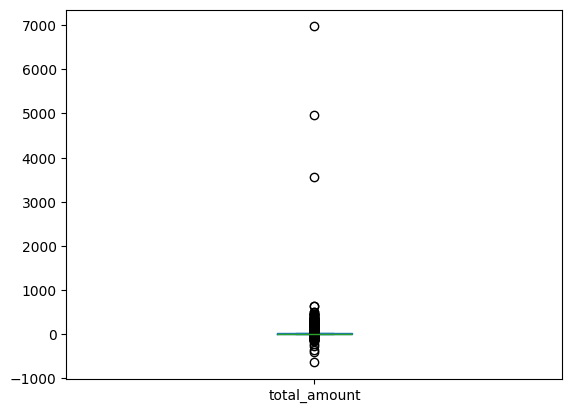

In [86]:
df['total_amount'].plot.box()

In [87]:
total_median=df['total_amount'].median()
total_median

14.15

In [88]:
def norm(value):
  if value<=0 or value>=1000:
    return total_median
  return value

In [89]:
%timeit df['total_amount'].apply(norm)

392 ms ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
#using numba
import numba

@numba.vectorize
def norm_numba(value):
  if value<=0 or value>1000:
    return total_median
  return value

In [13]:
df=pd.read_parquet(filename)

In [15]:
%%timeit
values=df['total_amount'].to_numpy()
norm_numba(values)

2.1 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Challenge


In [3]:
#for each vendorID what is the max number of passengers in a ride?
import pyarrow.parquet as pq
filename="/content/yellow_tripdata_2021-02.parquet"
columns=['VendorID', 'passenger_count']
counts={}
for batch in pq.ParquetFile(filename).iter_batches(batch_size=10_000, columns=columns):
  for i in range(len(batch)):
    vid=batch['VendorID'][i]
    count=batch['passenger_count'][i].as_py()

    if count is None:
      continue
    count=int(count)
    if count>counts.get(vid,0):
      counts[vid]=count

for vid, count in counts.items():
  print(f'{vid}->{count}')

1->6
2->9


Dask

In [5]:
import dask.dataframe as ddf
df=ddf.read_parquet(filename)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-02-01 00:40:47,2021-02-01 00:48:28,1.0,2.30,1.0,N,141,226,2,8.5,3.0,0.5,0.00,0.0,0.3,12.30,2.5,NaN
1,1,2021-02-01 00:07:44,2021-02-01 00:20:31,1.0,1.60,1.0,N,43,263,2,9.5,3.0,0.5,0.00,0.0,0.3,13.30,0.0,NaN
2,1,2021-02-01 00:59:36,2021-02-01 01:24:13,1.0,5.30,1.0,N,114,263,2,19.0,3.0,0.5,0.00,0.0,0.3,22.80,2.5,NaN
3,2,2021-02-01 00:03:26,2021-02-01 00:16:32,1.0,2.79,1.0,N,236,229,1,11.0,0.5,0.5,2.96,0.0,0.3,17.76,2.5,NaN
4,2,2021-02-01 00:20:20,2021-02-01 00:24:03,2.0,0.64,1.0,N,229,140,1,4.5,0.5,0.5,1.66,0.0,0.3,9.96,2.5,NaN


In [6]:
#max tip in percentage where payment is in cash
#create cash df
cash=df[df['payment_type']==2]
cash.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-02-01 00:40:47,2021-02-01 00:48:28,1.0,2.3,1.0,N,141,226,2,8.5,3.0,0.5,0.0,0.0,0.3,12.3,2.5,NaN
1,1,2021-02-01 00:07:44,2021-02-01 00:20:31,1.0,1.6,1.0,N,43,263,2,9.5,3.0,0.5,0.0,0.0,0.3,13.3,0.0,NaN
2,1,2021-02-01 00:59:36,2021-02-01 01:24:13,1.0,5.3,1.0,N,114,263,2,19.0,3.0,0.5,0.0,0.0,0.3,22.8,2.5,NaN
9,1,2021-02-01 00:28:13,2021-02-01 00:31:40,1.0,0.8,1.0,Y,75,74,2,5.0,0.5,0.5,0.0,0.0,0.3,6.3,0.0,NaN
10,1,2021-02-01 00:17:42,2021-02-01 00:28:23,1.0,2.1,1.0,N,74,24,2,9.0,0.5,0.5,0.0,0.0,0.3,10.3,0.0,NaN


In [9]:
tip_perc= cash['tip_amount']/cash['total_amount']
max_tip= tip_perc.max()
max_tip

<dask_expr.expr.Scalar: expr=((Filter(frame=ReadParquetFSSpec(327fa52), predicate=ReadParquetFSSpec(327fa52)['payment_type'] == 2))['tip_amount'] / (Filter(frame=ReadParquetFSSpec(327fa52), predicate=ReadParquetFSSpec(327fa52)['payment_type'] == 2))['total_amount']).max(), dtype=float64>

In [11]:
max_tip.compute()

0.16666666666666669

Polars (better memory usage and time complexity)

In [29]:
#using polars
import polars as pl

dfp=pl.read_parquet(filename)
dfp.estimated_size(unit='mb')

198.7181272506714

In [24]:
#using pandas
import pandas as pd
df=pd.read_parquet(filename)
df.memory_usage(deep=True).sum()/1_000_000

np.float64(282.308734)

In [34]:
#polars
%%timeit
dfp.group_by('VendorID').agg(
    pl.col('total_amount').sum()
).sort('VendorID')

19.9 ms ± 5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
#pandas
%%timeit
df.groupby('VendorID')['total_amount'].sum().sort_values()

27.7 ms ± 2.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
#using polars, find the median distance for rides with more than one passenger

dfp.filter(pl.col('passenger_count')>1)
dfp.select(pl.median('trip_distance'))

trip_distance
f64
1.69
